In [1]:
import numpy as np

from utils.loadData import loadData
from lstm.preprocessing import dataToTimeSeries, getDatasets, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExample
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadData()

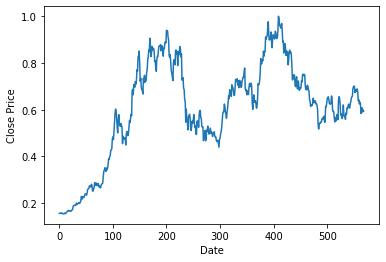

In [3]:
features = np.array(df["Close"]).reshape(-1, 1)
normalized_data, scaler = normalizeAtOnce(features)
normalized_data = normalized_data[2200:]
show_data_simple(normalized_data)

2022-04-21 12:10:08.386869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


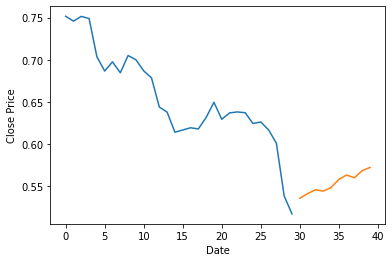

Input shape: (28, 30, 1)
Target shape: (28, 1)


In [4]:
config = {
    "past": 30, # try 10, 50, 100, 300
    "future": 10, # try 5, 50, 100
    "neurons": 100,
    "batch_size": 128, # large batches allow faster training
    "epochs": 10,
    "features": 1
}

dataset_train, dataset_val, x_test, y_test = getDatasets(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [5]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 122,210
Trainable params: 122,210
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.3235 - rmse: 0.5687
Epoch 1: val_loss improved from inf to 0.10771, saving model to checkpoints/model_checkpoint.h5
4/4 [==============================] - 4s 366ms/step - loss: 0.3235 - rmse: 0.5687 - val_loss: 0.1077 - val_rmse: 0.3282
Epoch 2/10
3/4 [=====================>........] - ETA: 0s - loss: 0.0718 - rmse: 0.2680
Epoch 2: val_loss improved from 0.10771 to 0.08759, saving model to checkpoints/model_checkpoint.h5
4/4 [==============================] - 0s 91ms/step - loss: 0.0747 - rmse: 0.2734 - val_loss: 0.0876 - val_rmse: 0.2960
Epoch 3/10
3/4 [=====================>........] - ETA: 0s - loss: 0.0407 - rmse: 0.2018
Epoch 3: val_loss improved from 0.08759 to 0.01365, saving model to checkpoints/model_checkpoint.h5
4/4 [==============================] - 0s 91ms/step - loss: 0.0392 - rmse: 0.1980 - val_loss: 0.0137 - val_rmse: 0.1168
Epoch 4/10
3/4 [=====================>........] - ETA: 0s - loss: 0.0349 - rmse

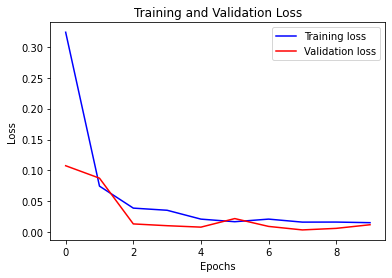

In [6]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [7]:
x, y = dataToTimeSeries(x_test, y_test, config["past"], config["future"])

In [8]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 1s 706ms/step - loss: 0.0023 - rmse: 0.0479
---- TEST RESULTS ----
MSE loss - 0.002296948106959462
RMSE - 0.047926485538482666


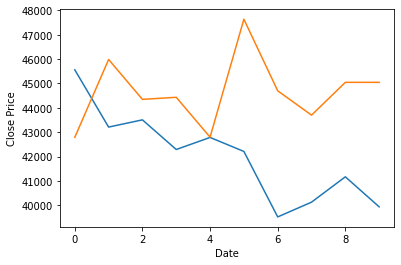

In [13]:
showRegressionExample(x[15], y[15], model, scaler)

In [10]:
# do grid search on past/future
# compare a gazilion of models
# are my labels X and Y really doing what they are supposed to? hmm check